<a href="https://colab.research.google.com/github/SPReddyK/AzureDevOpsPipelines-Templates/blob/master/handgesturerecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.12.0


In [13]:
# Unzip images, ignore this cell if files are already in the workspace
#here we need to mount the zipfolder to colab 
!unzip handgestdata.zip

Archive:  handgestdata.zip
   creating: handgestdata/00/
   creating: handgestdata/00/01_palm/
  inflating: handgestdata/00/01_palm/frame_00_01_0001.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0002.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0003.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0004.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0011.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0012.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0013.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0014.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0021.png  
  inflating: handgestdata/00/01_palm/frame_00_01_0022.png  
   creating: handgestdata/00/02_l/
  inflating: handgestdata/00/02_l/frame_00_02_0001.png  
  inflating: handgestdata/00/02_l/frame_00_02_0002.png  
  inflating: handgestdata/00/02_l/frame_00_02_0003.png  
  inflating: handgestdata/00/02_l/frame_00_02_0004.png  
  inflating: handgestdata/00/02_l/frame_00

In [14]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

1000


In [15]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


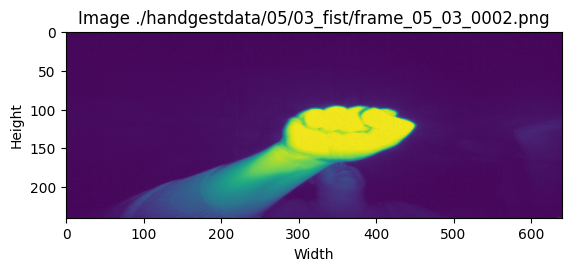

In [16]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [17]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1000
Labels loaded:  1000
3 ./handgestdata/05/03_fist/frame_05_03_0002.png


In [18]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [19]:
y_test

array([4, 2, 6, 8, 5, 7, 4, 5, 0, 2, 5, 7, 2, 7, 2, 1, 9, 9, 8, 5, 6, 7,
       7, 4, 5, 2, 3, 9, 3, 6, 6, 2, 4, 1, 7, 1, 9, 9, 3, 0, 4, 1, 5, 7,
       1, 7, 4, 3, 2, 2, 7, 7, 8, 7, 4, 2, 5, 5, 4, 4, 1, 0, 6, 3, 3, 1,
       8, 8, 7, 6, 3, 1, 1, 6, 1, 9, 0, 2, 9, 3, 7, 8, 7, 8, 5, 6, 1, 5,
       0, 4, 9, 0, 4, 5, 9, 2, 8, 9, 8, 4, 5, 0, 2, 0, 2, 6, 0, 0, 8, 5,
       4, 4, 9, 5, 9, 2, 9, 7, 2, 1, 1, 4, 5, 8, 2, 0, 9, 6, 8, 3, 1, 6,
       8, 1, 4, 0, 4, 5, 4, 7, 6, 6, 4, 9, 1, 5, 5, 6, 4, 4, 6, 0, 7, 4,
       6, 8, 3, 1, 8, 9, 1, 8, 6, 0, 8, 8, 1, 9, 5, 5, 8, 7, 5, 9, 9, 8,
       0, 0, 3, 7, 1, 7, 7, 4, 6, 2, 0, 8, 6, 6, 6, 4, 0, 1, 5, 3, 2, 3,
       5, 7, 4, 2, 1, 0, 2, 1, 8, 5, 1, 4, 8, 6, 4, 4, 0, 2, 8, 6, 3, 3,
       3, 2, 7, 6, 1, 3, 6, 0, 3, 2, 6, 1, 9, 7, 2, 2, 2, 8, 1, 2, 3, 3,
       5, 1, 3, 3, 2, 7, 9, 9, 9, 1, 9, 1, 1, 4, 5, 5, 4, 3, 2, 8, 1, 8,
       0, 8, 1, 9, 2, 9, 1, 5, 3, 0, 4, 3, 1, 3, 9, 9, 9, 1, 2, 1, 5, 5,
       0, 6, 4, 0, 6, 1, 3, 8, 8, 8, 2, 4, 3, 0])

In [20]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [21]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [22]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [23]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
11/11 - 44s - loss: 9.4694 - accuracy: 0.3100 - val_loss: 1.3221 - val_accuracy: 0.5667 - 44s/epoch - 4s/step
Epoch 2/5
11/11 - 36s - loss: 0.7253 - accuracy: 0.7814 - val_loss: 0.3141 - val_accuracy: 0.9333 - 36s/epoch - 3s/step
Epoch 3/5
11/11 - 36s - loss: 0.1061 - accuracy: 0.9800 - val_loss: 0.0397 - val_accuracy: 0.9900 - 36s/epoch - 3s/step
Epoch 4/5
11/11 - 36s - loss: 0.0190 - accuracy: 0.9914 - val_loss: 0.0612 - val_accuracy: 0.9867 - 36s/epoch - 3s/step
Epoch 5/5
11/11 - 36s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9933 - 36s/epoch - 3s/step


In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

10/10 [==============================] - 4s 355ms/step - loss: 0.0424 - accuracy: 0.9933
Test accuracy: 99.33%


In [25]:
predictions = model.predict(X_test) # Make predictions towards the test set

10/10 [==============================] - 4s 354ms/step


In [26]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(4, 4)

In [27]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

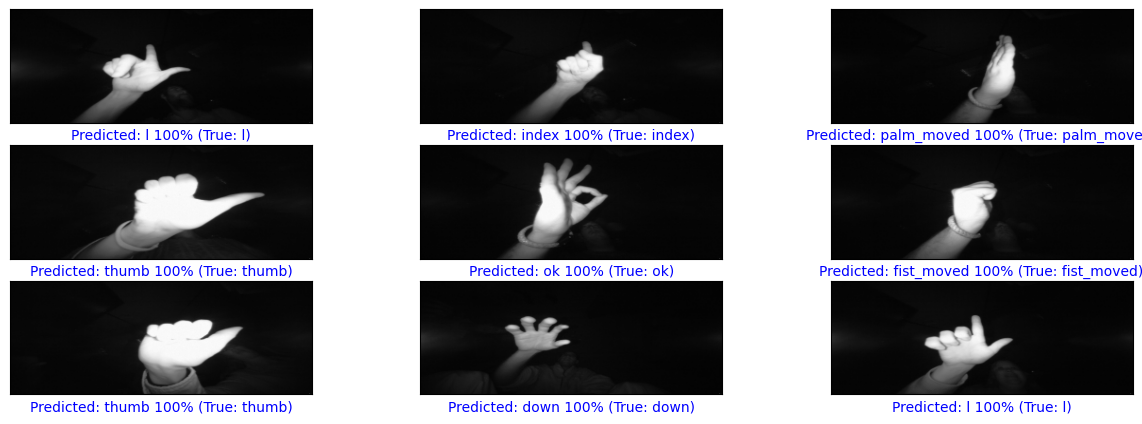

In [28]:
validate_9_images(predictions, y_test, X_test)

In [29]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [30]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,26,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,36,2,0,0,0,0,0,0,0
Actual L,0,0,32,0,0,0,0,0,0,0
Actual Fist (H),0,0,0,28,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,33,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,30,0,0,0,0
Actual Index,0,0,0,0,0,0,28,0,0,0
Actual OK,0,0,0,0,0,0,0,25,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,31,0
Actual C,0,0,0,0,0,0,0,0,0,29
